Use of ipyleaflet to select a map area and produce an earthquake catalogue, which is plotted
--

This uses https://github.com/ellisonbg/ipyleaflet, in particular this example https://github.com/ellisonbg/ipyleaflet/blob/master/examples/DrawControl.ipynb



jupyter nbextension enable --py --sys-prefix ipyleaflet

In [45]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [47]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime
from IPython.display import HTML
import folium

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [48]:
#map needs an initial centre and zoom
center = [-38.6892,176.0930]
zoom = 10

#default depth range (km)
dep1 = 0
dep2 = 20
dp1 = str(dep1)
dp2 = str(dep2)

In [49]:
def querypoly (gj):
    """form a query polygon for WFS from GEOJSON"""
    polygon = ''
    for c in gj['geometry']['coordinates'][0]:
        lon = c[0]
        lat = c[1]
        coord = str(lon)+'+'+str(lat)+','
        polygon += coord
    polygon = polygon[:-1]
    return polygon

In [50]:
def mappoly (gj):
    """form a list of coordinate pairs for plotting on a folium map from GEOJSON"""
    polygon = []
    for c in gj['geometry']['coordinates'][0]:
        lon = c[0]
        lat = c[1]
        polygon.append((lat,lon))
    return polygon

In [51]:
#ipwidget functions
def seldate1(d1):
  global date1
  date1 = d1['new']
  #date1 = date1.strftime("%Y-%m-%dT00:00:00.000Z")
  date1 = date1.strftime("%Y-%m-%d")

def seldate2(d2):
  global date2
  date2 = d2['new']
  #date2 = date2.strftime("%Y-%m-%dT00:00:00.000Z")
  date2 = date2.strftime("%Y-%m-%d")

def deprng(d):
  global dp1, dp2
  dp1, dp2  = d['new']
  dp1 = str(dp1)
  dp2 = str(dp2)
    
def pro_poly(c):
   #get the polgyon coordinates
    global qpoly
    gj = dc.last_draw
    qpoly = querypoly(gj)
    print ('polygon is', qpoly) #this cell is the polygon, the format is suitable for a GeoNet search 

In [52]:
def plot(p):
    global cat
    #get data
    url = "http://wfs.geonet.org.nz/geonet/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=geonet:quake_search_v1&outputFormat=csv&cql_filter=origintime>="+date1+"+AND+origintime<="+date2+"+AND+WITHIN(origin_geom,POLYGON((" + qpoly + "+)))+AND+depth>="+dp1+"+AND+depth<="+dp2
    cat = pd.read_csv(url, parse_dates=['origintime'], index_col='origintime')
    cat.sort_index(ascending=True, inplace=True) # sort by origintime(index), so events in time order
   
    #plot
    fig = plt.figure(figsize=(15, 15))

    d1 = datetime.datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.datetime.strptime(date2, "%Y-%m-%d")

    # magnitude vs time
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.set_xlim([d1,d2])
    ymax = 1.1 * cat.magnitude.max()
    ax1.set_ylim([0, ymax])
    # automatic locations
    automatic = cat.magnitude[cat['evaluationmode'] == 'automatic']
    ax1.plot(automatic, marker='o', color='red', linestyle='None', label='automatic')
    # manual locations
    manual = cat.magnitude[cat['evaluationmode'] == 'manual']
    ax1.plot(manual, marker='o', color='blue', linestyle='None', label='manual')
    plt.ylabel('magnitude')
    plt.legend(loc='best')

    # cumulative number
    ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)
    ax2.plot(cat.index, cat.reset_index().index, color='red', marker='None', label='cumnum')
    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylabel('cumulative number', color='red')

    # cumulative energy (normalised to 1.0), on same plot
    ax2a = ax2.twinx()
    ax2a.set_xlim([d1,d2])
    ax2a.set_ylim([0, 1])
    cat['energy'] = pow(10, (1.44 * cat['magnitude'] + 5.24))
    cat['cumeng'] = cat['energy'].cumsum()
    cat['cumeng'] = cat['cumeng'] / cat['cumeng'].max()
    ax2a.plot(cat.cumeng, color='blue', marker='None', label='cumeng')
    ax2a.tick_params(axis='y', colors='blue')
    ax2a.set_ylabel('normalised cumulative energy', color='blue')

    # depth
    ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)
    ax3.set_ylim([int(dp1), int(dp2)])
    # automatic locations
    automatic = cat.depth[cat['evaluationmode'] == 'automatic']
    ax3.plot(automatic, color='red', marker='o', linestyle='None', label='automatic')
    # manual locations
    manual = cat.depth[cat['evaluationmode'] == 'manual']
    ax3.plot(manual, color='blue', marker='o', linestyle='None', label='manual')
    plt.gca().invert_yaxis()
    ax3.set_ylabel('depth(km)')
    plt.legend(loc='best')

    plt.savefig('catevents.png', dpi=200)
 

In [53]:
d1 = widgets.DatePicker(description='Search start date:')
d1.observe(seldate1, names='value')

d2 = widgets.DatePicker(description='Search end date:')
d2.observe(seldate2, names='value')

d = widgets.IntRangeSlider(
    #default depth range
    value=[dep1, dep2],
    min=0,
    max=100,
    step=1,
    description='Depth range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')
d.observe(deprng, names='value')

widgets.HBox([d1, d2, d])

A Jupyter Widget

In [54]:
m = Map(center=center, zoom=zoom, layout=dict(width='400px', height='400px'))
m

A Jupyter Widget

In [55]:
dc = DrawControl()

def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)

m.add_control(dc)

Run all the cells above here. Hint: click in this cell, then, from the menu, click on Cell -> Run All Above
--
1. **Using the date widgets, select the start and end dates for catalogue search, and the depth range**
2. **Use the polgyon tool to draw the search area. The tool provides instructions.**


Then, run the cell below. Hint: click in this cell, then, from the menu, click on Cell -> Run All Above
--
1. **Click on the box 'Process polygon' to process the polygon of your search area**
2. **Click on the box 'Plot' to execute a QuakeSearch using your polygon search area and the date and depth ranges you selected**


**Process the polgyon**

In [56]:
c=widgets.Button(
    description='Process polygon',
    disabled=False,
    button_style='success',
    tooltip='Process polygon')
c.on_click(pro_poly)

widgets.HBox([c])

A Jupyter Widget

polygon is 175.743897+-38.909642,175.919678+-38.909642,175.910889+-38.999349,175.737305+-39.005325,175.743897+-38.909642


**Search and plot**

A Jupyter Widget

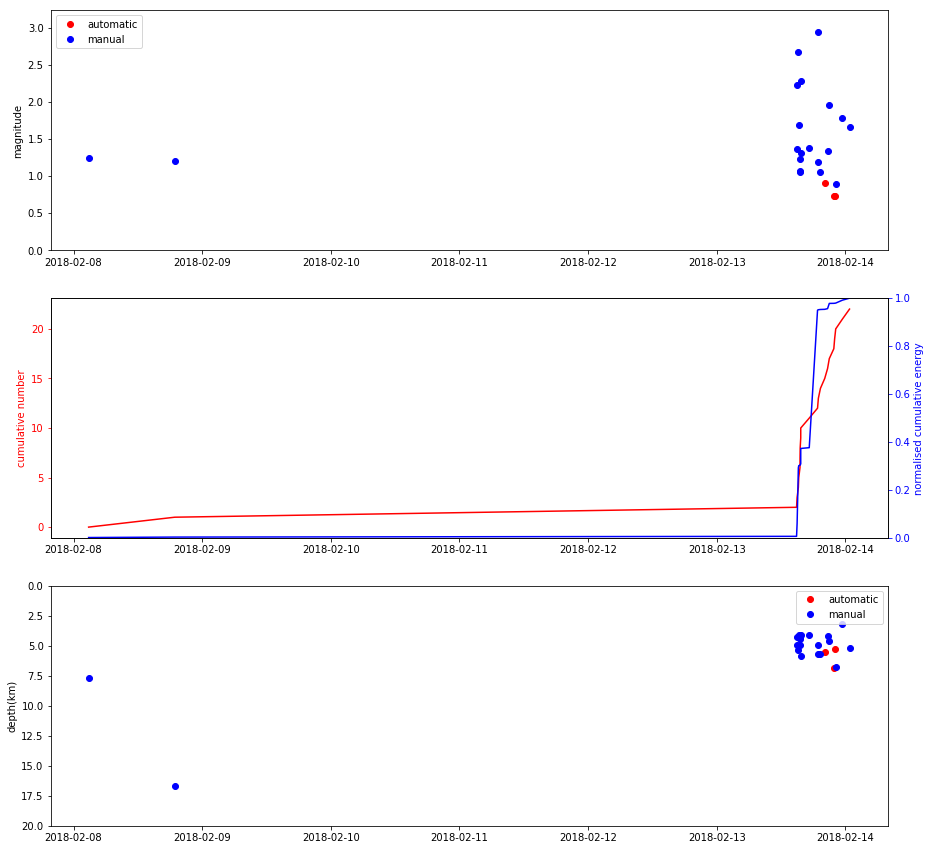

In [57]:
p=widgets.Button(
    description='Plot time series',
    disabled=False,
    button_style='success',
    tooltip='Click to plot')
p.on_click(plot)

widgets.HBox([p])

In [63]:
def emap(e):  
#make a map of epicentres
    global emap
    gj = dc.last_draw
    area = mappoly(gj)
    emap = folium.Map(location=center, zoom_start=zoom, control_scale=True)
    folium.PolyLine(area, color="blue", weight=5, opacity=0.5).add_to(emap)
    for lat, lon, mag, id in zip(cat['latitude'], cat['longitude'], cat['magnitude'], cat['publicid']):
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            popup=id,
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(emap)
    emap

In [64]:
e=widgets.Button(
    description='Make epicentre map',
    disabled=False,
    button_style='success',
    tooltip='Click to make')
e.on_click(emap)

widgets.HBox([e])

A Jupyter Widget

In [61]:
emap